In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lightgbm as lgb

'C:\\Users\\Winter\\data_science\\repos\\credit-admission-prediction-python'

In [ ]:
import os
os.chdir("..")

## Four key fairness criteria:
### **1. Demographic parity / statistical parity**

Demographic parity says the model is fair if the composition of people who are selected by the model matches the group membership percentages of the applicants.

### **2. Equal opportunity**

Equal opportunity fairness ensures that the proportion of people who should be selected by the model ("positives") that are correctly selected by the model is the same for each group. We refer to this proportion as the true positive rate (TPR) or sensitivity of the model.

### **3. Equal accuracy**

Alternatively, we could check that the model has equal accuracy for each group. That is, the percentage of correct classifications (people who should be denied and are denied, and people who should be approved who are approved) should be the same for each group. If the model is 98% accurate for individuals in one group, it should be 98% accurate for other groups.

In [147]:
# copy paste from notebook 3
def get_confusion_matrix(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    cm_matrix = pd.DataFrame(data=cm, 
                             columns=['Actual Negative:0', 'Actual Positive:1'], 
                             index=['Predict Negative:0', 'Predict Positive:1'])
    return cm_matrix

def get_stats(X, y, model, group_one, with_gender = True):
    
    if with_gender == False:
        X = X.drop('code_gender', axis = 1)
        
    preds = model.predict(X)
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("1. Demographic parity / statistical parity")
    print("\nTotal observations:", len(preds))
    print("Group 0:", len(preds_zero), "({}%)".format(round(len(preds_zero)/len(preds)*100, 2)))
    print("Group 1:", len(preds_one), "({}%)".format(round(len(preds_one)/len(preds)*100, 2)))
    
    print("\nTotal approvals:", preds.sum())
    print("Group 0:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group 1:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\n2. Equal opportunity")
    cm_zero = get_confusion_matrix(y_zero, preds_zero)
    cm_one = get_confusion_matrix(y_one, preds_one)
    
    sns.set(rc={'figure.figsize':(20,8)})
    fig, ax = plt.subplots(1,2)
    sns.heatmap(cm_zero, annot=True, fmt='d', cmap='YlGnBu', ax = ax[0])
    ax[0].set_title('Group 0')
    sns.heatmap(cm_one, annot=True, fmt='d', cmap='YlGnBu', ax = ax[1])
    ax[1].set_title('Group 1')
    fig.show()
    
    print("\nSensitivity / Recall:")
    print("Group 0: {}%".format(round(cm_zero.iloc[1,1] / (cm_zero.iloc[0,1] + cm_zero.iloc[1,1]) * 100, 2)))
    print("Group 1: {}%".format(round(cm_one.iloc[1,1] / (cm_one.iloc[0,1] + cm_one.iloc[1,1]) * 100, 2)))

    print("\n3. Equal accuracy")
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group 0: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group 1: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))

In [15]:
import pickle

infile = open('data/interim/model_training_lgbm','rb')
lgbm_dict = pickle.load(infile)
infile.close()

1. Demographic parity / statistical parity

Total observations: 4000
Group 0: 2697 (67.42%)
Group 1: 1303 (32.57%)

Total approvals: 480
Group 0: 287 (59.79% of approvals)
Group 1: 193 (40.21% of approvals)

2. Equal opportunity

Sensitivity / Recall:
Group 0: 6.97%
Group 1: 4.66%

3. Equal accuracy

Overall accuracy: 87.9%
Group 0: 89.32%
Group 1: 84.96%


C:\Users\Winter\AppData\Local\Temp\ipykernel_27292\2489863384.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


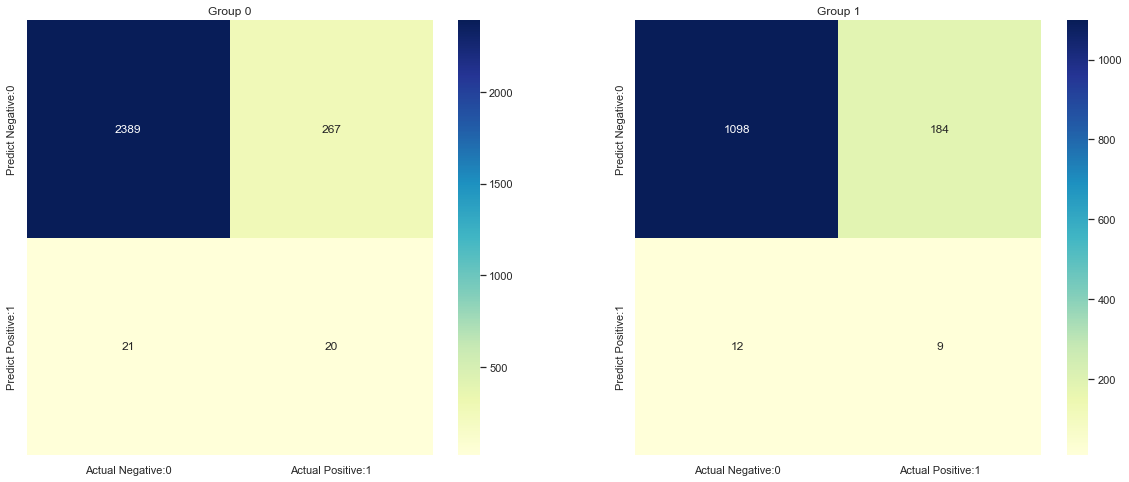

In [148]:
get_stats(lgbm_dict['X_test_data'], lgbm_dict['y_test_data'], lgbm_dict['classifier'], lgbm_dict['X_test_data']["code_gender"]==1)

### **4.Group unaware / "Fairness through unawareness"**

Group unaware fairness removes all group membership information from the dataset. For instance, we can remove gender data to try to make the model fair to different gender groups. Similarly, we can remove information about race or age.

#### Fitting model with no code_gender in the feature set

In [138]:
lgbm_no_gender = lgb.LGBMClassifier(**lgbm_dict['classifier'].get_params())
lgbm_no_gender.fit(lgbm_dict['X_train_data'].drop('code_gender', axis = 1),
                   lgbm_dict['y_train_data'],
                   categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(class_weight='balanced', learning_rate=0.11896361988417897,
               max_bin=2, max_depth=10, min_data_in_leaf=5, n_estimators=1317,
               num_leaves=18, objective='binary', reg_alpha=0.21374679841071625,
               reg_lambda=0.7184760864059272)

1. Demographic parity / statistical parity
Total observations: 4000
Group 0: 2697 (67.42%)
Group 1: 1303 (32.57%)

Total approvals: 544
Group 0: 356 (65.44% of approvals)
Group 1: 188 (34.56% of approvals)
2. Equal opportunity

Sensitivity / Recall:
Group 0: 5.62%
Group 1: 4.79%
3. Equal accuracy

Overall accuracy: 86.3%
Group 0: 86.76%
Group 1: 85.34%


C:\Users\Winter\AppData\Local\Temp\ipykernel_27292\1414134634.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


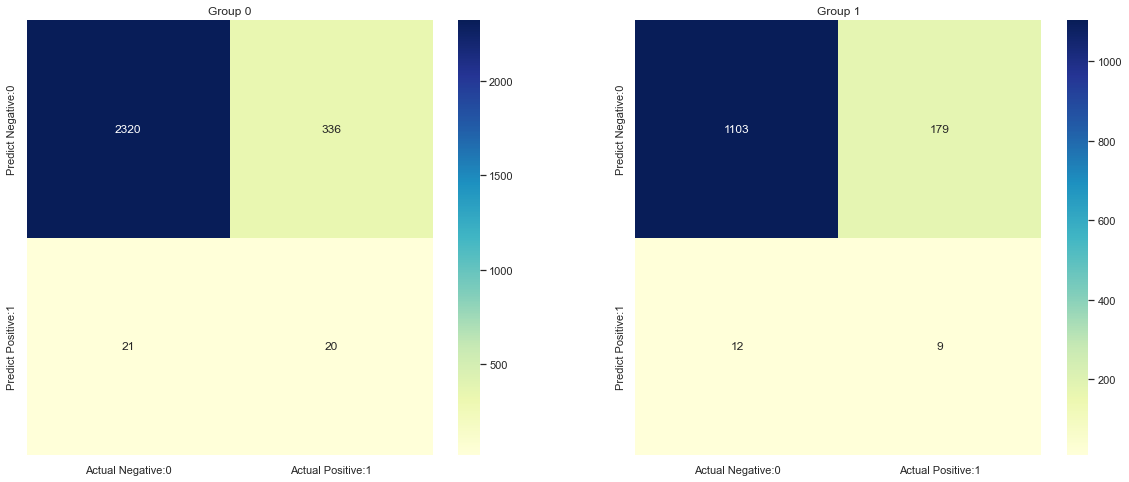

In [142]:
get_stats(lgbm_dict['X_test_data'],
          lgbm_dict['y_test_data'],
          lgbm_no_gender,
          lgbm_dict['X_test_data']["code_gender"]==1,
          with_gender = False)